In [23]:
import json
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
get_ipython().magic(u'matplotlib inline')
data = json.load(open('/Users/Sage/Desktop/cuisine_data/train.json')) 

## 1. Process raw recipe data

In [25]:
def ingredients_per_cuisine(data):
    IngrePerCuisineDict = {}
    cuisines = []
    all_ingredients = []
    
    for i in range(len(data)):       
        thiscuisine = data[i]['cuisine']
        thisingredients = data[i]['ingredients']
        if thiscuisine not in IngrePerCuisineDict.keys():
            cuisines.append(thiscuisine)
            IngrePerCuisineDict[thiscuisine] = thisingredients           
        else: 
            ingrelist = IngrePerCuisineDict[thiscuisine]
            ingrelist.extend(thisingredients)
            IngrePerCuisineDict[thiscuisine] = ingrelist
                 
        all_ingredients.extend(thisingredients)
        
    all_ingredients = list(set(all_ingredients)) # unique list of ALL ingredients
    num_unique = len(all_ingredients)
    num_cuisines = len(cuisines)
    
    return IngrePerCuisineDict,cuisines,num_unique,num_cuisines,all_ingredients

In [26]:
def count_matrix_cuisine(IngrePerCuisineDict,cuisines,num_unique,num_cuisines,all_ingredients):
    tfm = np.zeros((num_cuisines,num_unique))
    ii = 0    
    for cuisine in cuisines:
        allingredients = IngrePerCuisineDict[cuisine]

        for ingredient in allingredients:
            jj = all_ingredients.index(ingredient) 
            tfm[ii,jj] += 1
        ii += 1
    return tfm

In [27]:
def count_matrix_recipe(data,all_ingredients):
    tfm = np.zeros((len(data),num_unique))   
    for ii in range(len(data)):       
        thisrecipe = data[ii]['ingredients']
        for ingredient in thisrecipe:
            jj = all_ingredients.index(ingredient) 
            tfm[ii,jj] += 1
    return tfm

In [28]:
def tfm_tfidf(tfm):
    countsMatrix = sparse.csr_matrix(tfm)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(tfm)  
    return tfidf

In [29]:
temp = data
IngrePerCuisineDict,cuisines,num_unique,num_cuisines,all_ingredients = ingredients_per_cuisine(temp)
tfm_cuisine = count_matrix_cuisine(IngrePerCuisineDict,cuisines,num_unique,num_cuisines,all_ingredients)
temp = data
tfm_recipe  = count_matrix_recipe(temp,all_ingredients)

In [30]:
tfm_cuisine_tfidf = tfm_tfidf(tfm_cuisine)
tfm_recipe_tfidf = tfm_tfidf(tfm_recipe)

## 2. Create stratified train/test sets

In [50]:
data = json.load(open('/Users/Sage/Desktop/cuisine_data/train.json')) 
train_cuisine = [recipe['cuisine'] for recipe in data]
recipe_length = [len(recipe['ingredients']) for recipe in data]
labelencoder = LabelEncoder()
cuisine_label = labelencoder.fit_transform(train_cuisine)

In [51]:
# Adding recipe length to the matrix
recipe_length = np.array(recipe_length)
X_data = np.hstack((tfm_recipe_tfidf.toarray(),recipe_length.reshape(len(recipe_length),1)))


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    cuisine_label,test_size=0.25,random_state=0,stratify=cuisine_label)

## 3. Data exploration

## PCA

In [70]:
from scipy.spatial import distance
pca = PCA(n_components=2)
components = pca.fit_transform(tfm_cuisine_tfidf.toarray())
print(pca.explained_variance_ratio_)  
components_df = pd.DataFrame(components)
components_df.columns = ['PC1', 'PC2']
distance_mat = distance.squareform(distance.pdist(components))

[ 0.25231718  0.13862002]


In [87]:
def distance_total(prediction, y_test,distance_mat):
    wrong_pred  = prediction[prediction != y_test]
    wrong_label = y_test[prediction != y_test]
    total_dist = 0
    for i in range(len(wrong_pred)):
        ii = wrong_pred[i]
        jj = wrong_label[i]
        total_dist += distance_mat[ii,jj]
    return total_dist

In [90]:
from sklearn.cluster import KMeans

def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

labels = kmeans_cultures(5)
i = 0 
j = 0 
effect_on_cluster = [0 for cuisine in cuisines]
for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(IngrePerCuisineDict[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: 
            if labels[j] == labels[i]: 
                setB_forA.extend(set(IngrePerCuisineDict[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection       
    i += 1

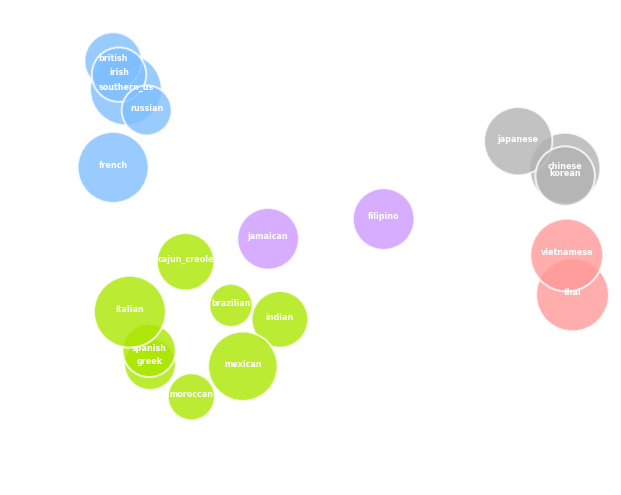

In [104]:
from pylab import *
from scipy import *
import matplotlib.pyplot as plt

rdata = reduced_data
i=0
figureRatios = (10,15)
x = []
y = []
color = []
area = []
colorPalette = ['#ff9999','#ace600', '#80bfff','#b3b3b3', '#cc99ff'] 

plt.figure(1, figsize=figureRatios)


for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*12000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=8,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 
plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes

plt.show()

## Top-ten ingredients per cuisine (tf-idf weighted)

In [98]:
np_ingredients = np.array(all_ingredients)
top_ten_tfidf = {}
top_ten_tfidf_counts = {}
#tfm_cuisine_tfidf = tfm_cuisine_tfidf.toarray()
for ii in range(tfm_cuisine_tfidf.shape[0]):
    cuisine = cuisines[ii]
    thisindex = np.argsort(tfm_cuisine_tfidf[ii])
    thisindex = np.flip(thisindex[len(thisindex)-10:],axis=0)
    top_ten_tfidf[cuisine] = np_ingredients[thisindex]
    top_ten_tfidf_counts[cuisine] = np.flip(np.sort(tfm_cuisine_tfidf[ii]),axis=0)[:10]

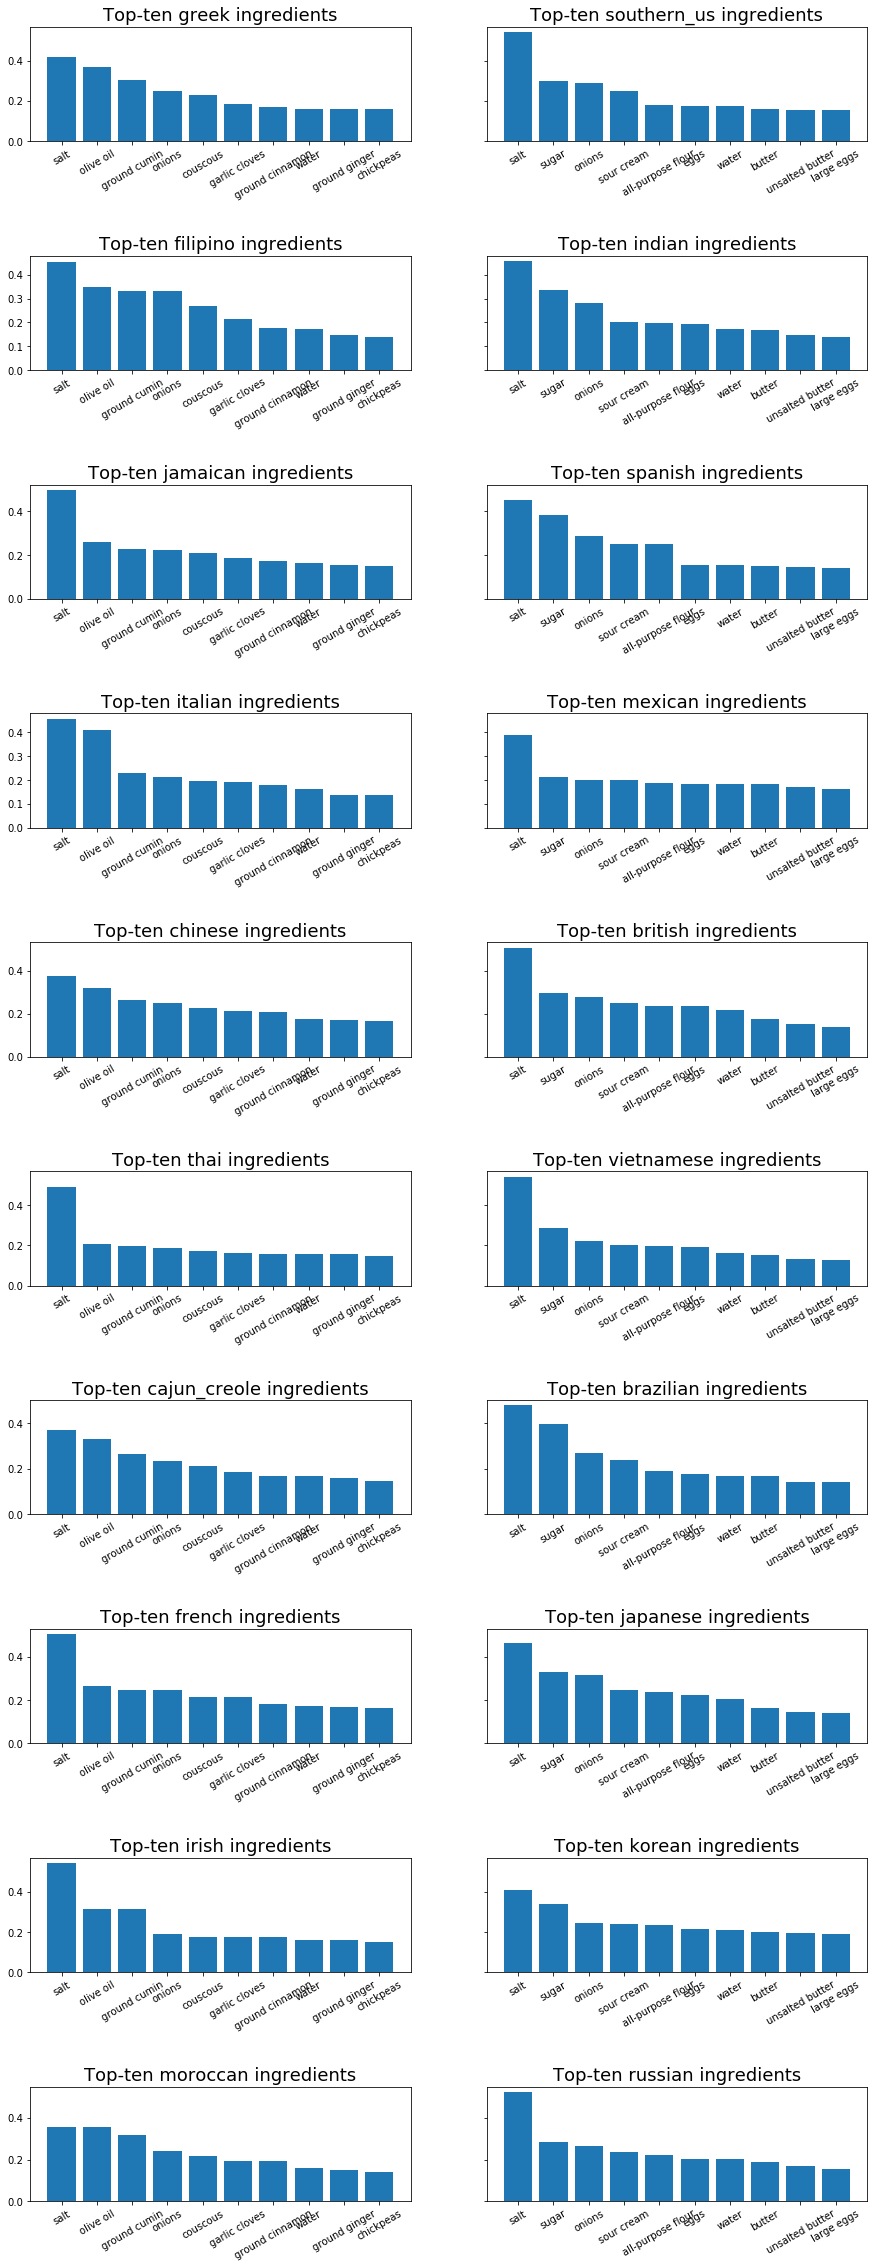

In [141]:
from itertools import product
f2, axarr2 = plt.subplots(10, 2, sharex='col', sharey='row', figsize=(15, 40))
plt.subplots_adjust(hspace=1)

sub_idx = product([0,1,2,3,4,5,6,7,8,9],[0,1])

for cuisine,idx in zip(cuisines,sub_idx):
    plt.sca(axarr2[idx[0], idx[1]])
    plt.xticks(rotation=30,fontsize=10,visible=True)
    ax = axarr2[idx[0], idx[1]].bar(np.arange(0,10),top_ten_tfidf_counts[cuisine],tick_label = top_ten_tfidf[cuisine])
    axarr2[idx[0], idx[1]].set_title('Top-ten {} ingredients'.format(cuisine),fontsize=18)

# OLD CODE!! SAVED JUST IN CASE!! IGNORE!!

In [ ]:
def CombineSpaces(row): 
    return " ".join([item.replace(' ', '') for item in row])

In [4]:
train_set = json.load(open('/Users/Sage/Desktop/cuisine_data/train.json')) 
test_set = json.load(open('/Users/Sage/Desktop/cuisine_data/test.json'))
train_text = [CombineSpaces(recipe['ingredients']).lower() for recipe in train_set]
train_cuisine = [recipe['cuisine'] for recipe in train_set]
train_cuisine = np.array(train_cuisine)
train_text = np.array(train_text)
unique, counts = np.unique(train_cuisine,return_counts=True)
prop = counts/sum(counts)
test_text = [CombineSpaces(recipe['ingredients']).lower() for recipe in test_set]

In [5]:
X_train = X_valid = y_train = y_valid = []
for cuis in unique:
    temp_text = train_text[train_cuisine == cuis]
    temp_label = train_cuisine[train_cuisine == cuis]
    this_X_train, this_X_valid, this_y_train, this_y_valid = train_test_split(temp_text,temp_label, 
                                                                              test_size=0.25, random_state=0)
    X_train = np.append(X_train,this_X_train)
    X_valid = np.append(X_valid,this_X_valid)
    y_train = np.append(y_train,this_y_train)
    y_valid = np.append(y_valid,this_y_valid)
    
rand_vec1 = np.random.permutation(len(X_train))
rand_vec2 = np.random.permutation(len(X_valid))

X_train = X_train[rand_vec1]
y_train = y_train[rand_vec1]
X_valid = X_valid[rand_vec2]
y_valid = y_valid[rand_vec2]

In [6]:
tfidf_vec = TfidfVectorizer(binary=True)
X_train = tfidf_vec.fit_transform(X_train)
X_valid = tfidf_vec.transform(X_valid)
X_train = X_train.astype('float16')
X_valid = X_valid.astype('float16')

In [62]:
recipe_len = []
for recipe in data:
    recipe_len.append(len(recipe['ingredients']))

In [8]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_valid = labelencoder.transform(y_valid)

In [85]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(class_weight = None)
LogReg = LogReg.fit(X_train,y_train)
print(LogReg.score(X_test, y_test))
prediction = LogReg.predict(X_test)

0.758145615447


In [86]:
wrong_pred  = prediction[prediction != y_test]
wrong_label = y_test[prediction != y_test]
total_dist = 0
for i in range(len(wrong_pred)):
    ii = wrong_pred[i]
    jj = wrong_label[i]
    total_dist += distance_mat[ii,jj]
total_dist

1375.9676414310018

In [81]:
wrong_pred  = prediction[prediction != y_test]
wrong_label = y_test[prediction != y_test]
total_dist = 0
for i in range(len(wrong_pred)):
    ii = wrong_pred[i]
    jj = wrong_label[i]
    total_dist += distance_mat[ii,jj]
total_dist

1375.9676414310018

In [2]:
data[0]

{'cuisine': 'greek',
 'id': 10259,
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [3]:
data = json.load(open('/Users/Sage/Desktop/cuisine_data/train.json')) 

In [12]:
recipe_len = []
for recipe in data:
    recipe_len.append(len(recipe['ingredients']))
recipe_len = np.array(recipe_len)

In [53]:
X_train.shape

(29830, 6715)